# Notebook #5

## Computing the true X-ray luminosity

In [304]:
import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

from data_loader import DataLoader
from config_loader import ConfigLoader

In [305]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

config = ConfigLoader("/Users/admin/Documents/GitHub/matched-catalog-matching/src/configs/config.yaml")

edff_cdfs = pd.read_csv(config.EDFF_CDFS_PATH)
edff_erosita = pd.read_csv(config.EDFF_EROSITA_PATH)

In [306]:
# Remove sources with no provided redshift
edff_cdfs = edff_cdfs[(edff_cdfs['zspec'] > 0)]
edff_cdfs.head()

,OutID,InID,Rel,LR,flag,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_NB0816_MAG,HSC_NB0816_MAGERR,HSC_NB0816_FLUX,HSC_NB0816_FLUXERR,HSC_NB0816_CHISQ,HSC_NB0816_DRIFT,HSC_NB0816_VALID,HSC_NB0921_MAG,HSC_NB0921_MAGERR,HSC_NB0921_FLUX,HSC_NB0921_FLUXERR,HSC_NB0921_CHISQ,HSC_NB0921_DRIFT,HSC_NB0921_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,lp_mods,lp_chis,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,lp_SFR_med_min68,lp_SFR_med_max68,lp_SFR_best,lp_sSFR_med,lp_sSFR_med_min68,lp_sSFR_med_max68,lp_sSFR_best,ez_z_phot,ez_z_phot_chi2,ez_z_phot_risk,ez_z_min_risk,ez_min_risk,ez_z_raw_chi2,ez_raw_chi2,ez_z_ml,ez_z_ml_chi2,ez_z_ml_risk,ez_z025,ez_z160,ez_z500,ez_z840,ez_z975,ez_nusefilt,ez_lc_min,ez_lc_max,ez_star_min_chi2,ez_star_teff,Seq,RAJ2000,DEJ2000,logPB,WAV,errPos,Angle,FB,e_FB,e_fb_lc,SB,e_SB,e_sb_lc,HB,e_HB,e_hb_lc,Ph,CPCat,CPoff,CPNote,RAWdeg,DEWdeg,RmagW,RAGSdeg,DEGSdeg,zmagGS,RAGdeg,DEGdeg,zmagG,RACdeg,DECdeg,F125Wmag,RATdeg,DETdeg,KsmagT,RASdeg,DESdeg,_3_6mag,RAVdeg,DEVdeg,VLAmag,zspec,q_zspec,r_zspec,zL10,zR11,zH14,zS14,zS15,zS16,zF,r_zF,e_zF,e_zf_lc,FExp,SExp,HExp,BR,e_BR,e_br_lc,Gamma,e_Gamma,e_gamma_lc,FFB,FSB,FHB,LX,NH,LXc,OType,f_X11ID,X11ID,f_X16ID,X16ID,R13ID,recno
0,0,458822,0.997,14.450,1.0,458823,52.899085,-27.859726,20621.585139,17170.794960,0.003822,0.004051,52.899084,-27.859724,55_9804,6672,1,0.0,ExpGalaxy,0.007664,1.611016,0.013837,23.382250,0.009353,0.898824,0.017911,True,3.810336,0.010238,22.447592,0.002926,1.017300,0.027875,True,2.952419,0.006897,22.724555,0.002544,1.556026,0.003955,True,4.174383,0.008332,22.348519,0.002174,2.399218,0.002706,True,5.360851,0.043437,22.076916,0.008824,1.095089,0.023550,True,22.159055,0.017409,4.970246,0.079456,0.912490,0.009173,True,22.209646,0.009310,4.743968,0.040558,1.143135,0.011625,True,19.968416,0.013417,20.649141,0.000732,263.911946,0.139119,True,25.495188,0.020691,20.383854,0.000884,358.910830,0.076751,True,2.0269,1.9673,2.0954,2.0760,56.07560,NaN,NaN,7,2.36,60.5269,23,240,1573.160,5,8.064000e+08,0.2,0,-22.36209,-23.86975,-24.15572,10.85561,10.79791,10.91246,10.86241,2.10018,2.03206,2.16818,2.0970,-8.75609,-8.84821,-8.66402,-8.765,1.970717,44.655087,0.008678,1.959440,0.008256,2.004166,4.398533e+01,1.996703,4.396116e+01,0.014285,1.869814,1.914355,1.970717,1.996113,2.007755,7,3640.981999,45020.337852,928.44850,6500.0,1,52.899178,-27.859588,0.0,-8,0.53,12.04,886.7,38.2,39.3,604.3,28.2,29.4,282.9,26.1,27.3,E,GEMS,0.52,,52.899048,-27.859669,21.97,0.0,0.0,0.0,52.899028,-27.859646,22.27,0.0,0.0,0.0,52.899017,-27.859646,20.70,52.899053,-27.859624,20.25,0.000000,0.000000,0.00,1.628,Secure,16,1.63,1.64,1.62,0.0,0.0,0.0,1.628,zSpec,0.00,0.00,120000.0,110000.0,130000.0,0.374,0.038,0.040,1.78,0.10,0.11,2.400000e-14,1.100000e-14,1.300000e-14,3.600000e+44,8.900000e+20,3.800000e+44,AGN,,1,,127,1059,1
2,2,432521,1.000,127.600,1.0,432522,52.917198,-27.796322,20278.546181,18529.548059,0.002460,0.002386,52.917196,-27.796321,56_1901,974,6,0.0,ExpGalaxy,0.007767,3.546491,0.011104,22.525503,0.003410,1.966725,0.060761,True,3.993926,0.009144,22.396500,0.002493,1.529157,0.032150,True,6.764130,0.00795

In [307]:
# Remove sources with no provided redshift
edff_erosita = edff_erosita[
    (edff_erosita['ML_FLUX_P2'] > 0) &
    (edff_erosita['ML_FLUX_P3'] > 0)
]
edff_erosita.head()

,OutID,InID,Rel,LR,flag,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_NB0816_MAG,HSC_NB0816_MAGERR,HSC_NB0816_FLUX,HSC_NB0816_FLUXERR,HSC_NB0816_CHISQ,HSC_NB0816_DRIFT,HSC_NB0816_VALID,HSC_NB0921_MAG,HSC_NB0921_MAGERR,HSC_NB0921_FLUX,HSC_NB0921_FLUXERR,HSC_NB0921_CHISQ,HSC_NB0921_DRIFT,HSC_NB0921_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,lp_mods,lp_chis,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,lp_SFR_med_min68,lp_SFR_med_max68,lp_SFR_best,lp_sSFR_med,lp_sSFR_med_min68,lp_sSFR_med_max68,lp_sSFR_best,ez_z_phot,ez_z_phot_chi2,ez_z_phot_risk,ez_z_min_risk,ez_min_risk,ez_z_raw_chi2,ez_raw_chi2,ez_z_ml,ez_z_ml_chi2,ez_z_ml_risk,ez_z025,ez_z160,ez_z500,ez_z840,ez_z975,ez_nusefilt,ez_lc_min,ez_lc_max,ez_star_min_chi2,ez_star_teff,IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,M

## Computing Fluxes and Luminosities

In [308]:
def compute_luminosity(flux, redshift):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.29, Tcmb0=2.725)
    dl = cosmo.luminosity_distance(redshift).value  # Mpc
    lum_dist = dl * 3.086e24  # convert to cm
    L = 4 * np.pi * lum_dist**2 * flux
    return L

def compute_flux(mAB: float, wavelength: float) -> float:
    JY = 1e-23  # Janskys
    C_LIGHT = 299792458.0  # m/s
    wavelength_m = wavelength * 1e-10
    f_nu = 3631 * JY * 10 ** (-0.4 * mAB)
    nu = C_LIGHT / wavelength_m
    nuf_nu = nu * f_nu

    return nuf_nu

#in Angstroms
LAMBDA_MID_X = (6.19 + 24.80 ) / 2 
LAMBDA_MID_U = (3147.51	+ 4018.39) / 2
LAMBDA_MID_G = (3942.85 + 5547.08) / 2
LAMBDA_MID_R2 = (5021.21 + 7216.76) / 2
LAMBDA_MID_I = (6440.47 + 8643.90) / 2
LAMBDA_MID_Z = (8564.13 + 9490.57) / 2
LAMBDA_MID_CH1 = (31296.24 + 39614.36) / 2
LAMBDA_MID_CH2 = (39173.28 + 50560.57) / 2

wavelength_dict = {
    'LAMBDA_MID_X': LAMBDA_MID_X,
    'LAMBDA_MID_U': LAMBDA_MID_U,
    'LAMBDA_MID_G': LAMBDA_MID_G,
    'LAMBDA_MID_R2': LAMBDA_MID_R2,
    'LAMBDA_MID_I': LAMBDA_MID_I,
    'LAMBDA_MID_Z': LAMBDA_MID_Z,
    'LAMBDA_MID_CH1': LAMBDA_MID_CH1,
    'LAMBDA_MID_CH2': LAMBDA_MID_CH2
}

wavelengths = [
    LAMBDA_MID_X, 
    LAMBDA_MID_U, 
    LAMBDA_MID_G, 
    LAMBDA_MID_R2, 
    LAMBDA_MID_I,
    LAMBDA_MID_Z,
    LAMBDA_MID_CH1,
    LAMBDA_MID_CH2
]

edff_magnitude_columns = [
    'CFHT_u_MAG', 'HSC_g_MAG', 'HSC_r_MAG', 
    'HSC_i_MAG', 'HSC_z_MAG', 'IRAC_CH1_MAG', 
    'IRAC_CH2_MAG'
]
flux_column_names = [
    'F_u', 'F_g', 'F_r', 
    'F_i', 'F_z', 'F_ch1', 
    'F_ch2'
]
luminosity_column_names = [
    'L_u', 'L_g', 'L_r', 
    'L_i', 'L_z', 'L_ch1', 
    'L_ch2'
]

edff_cdfs_computed = pd.DataFrame({
    'edffID': edff_cdfs['InID'], 
    'z': edff_cdfs['zspec'], 
})
edff_erosita_computed = pd.DataFrame({
    'edffID': edff_erosita['InID'], 
    'z': edff_erosita['lp_zPDF'], 
})

edff_cdfs_computed['F_x'] = edff_cdfs['FSB']
edff_erosita_computed['F_x'] = edff_erosita['ML_FLUX_P3'] + edff_erosita['ML_FLUX_P2']

# Calculate flux values from magnitudes
for i, col in enumerate(edff_magnitude_columns):
    col_name = flux_column_names[i]
    edff_cdfs_computed[col_name] = edff_cdfs[col].apply(
        compute_flux, wavelength=wavelengths[i+1]
    )
    edff_erosita_computed[col_name] = edff_erosita[col].apply(
        compute_flux, wavelength=wavelengths[i+1]
    )

# Calculate luminosities
edff_cdfs_computed['L_x'] = edff_cdfs_computed.apply(
    lambda row: compute_luminosity(row['F_x'], row['z']), axis=1
)
edff_erosita_computed['L_x'] = edff_erosita_computed.apply(
    lambda row: compute_luminosity(row['F_x'], row['z']), axis=1
)

for i, col in enumerate(flux_column_names):
    luminosity_column_name = luminosity_column_names[i]
    edff_cdfs_computed[luminosity_column_name] = edff_cdfs_computed.apply(
        lambda row: compute_luminosity(row[col], row['z']), axis=1
    )
    edff_erosita_computed[luminosity_column_name] = edff_erosita_computed.apply(
        lambda row: compute_luminosity(row[col], row['z']), axis=1
    )

# Drop rows with NaN values
edff_cdfs_computed = edff_cdfs_computed.dropna()
edff_erosita_computed = edff_erosita_computed.dropna()



In [309]:
print("Length: ", len(edff_erosita_computed))
edff_erosita_computed.head(10)

Length:  50


,edffID,z,F_x,F_u,F_g,F_r,F_i,F_z,F_ch1,F_ch2,L_x,L_u,L_g,L_r,L_i,L_z,L_ch1,L_ch2
0,702458,0.4681,2.283583e-13,1.675463e-12,1.148605e-12,1.045975e-12,7.364350e-13,4.410474e-13,6.601545e-13,6.671519e-13,1.885239e+44,1.383198e+45,9.482442e+44,8.635165e+44,6.079725e+44,3.641118e+44,5.449982e+44,5.507750e+44
1,176205,0.9199,1.074221e-13,3.015700e-13,7.751326e-13,4.312433e-13,3.159836e-13,4.743950e-13,6.061130e-13,5.931541e-13,4.617794e+44,1.296370e+45,3.332092e+45,1.853802e+45,1.358331e+45,2.039300e+45,2.605521e+45,2.549814e+45
2,585616,0.3461,9.833269e-14,1.735944e-13,3.701700e-13,9.437855e-13,1.330381e-12,1.452205e-12,5.959372e-13,4.971499e-13,3.972641e+43,7.013212e+43,1.495487e+44,3.812893e+44,5.374741e+44,5.866907e+44,2.407586e+44,2.008486e+44
3,543596,0.9900,8.544334e-14,7.084513e-13,3.659724e-13,3.304306e-13,2.199072e-13,2.484231e-13,2.039339e-13,2.770789e-13,4.406237e+44,3.653420e+45,1.887287e+45,1.704001e+45,1.134042e+45,1.281096e+45,1.051669e+45,1.428871e+45
4,820988,1.0200,8.559297e-14,4.228601e-13,5.169892e-13,2.506506e-13,2.418126e-13,2.855696e-13,2.946221e-13,2.616640e-13,4.753214e+44,2.348259e+45,2.870984e+45,1.391932e+45,1.342852e+45,1.585847e+45,1.636118e+45,1.453093e+45
5,311114,0.9335,7.694618e-14,1.873184e-13,1.957233e-13,2.612063e-13,2.704413e-13,3.243100e-13,1.505017e-13,1.123298e-13,3.430173e+44,8.350440e+44,8.725121e+44,1.164428e+45,1.205597e+45,1.445737e+45,6.709196e+44,5.007537e+44
6,929219,1.0700,2.878898e-14,3.091857e-13,3.612169e-13,2.373746e-13,2.200948e-13,2.613289e-13,2.354029e-13,2.095032e-13,1.800330e+44,1.933505e+45,2.258884e+45,1.484431e+45,1.376371e+45,1.634230e+45,1.472101e+45,1.310136e+45
7,254169,0.7018,8.253210e-14,5.561184e-13,3.630041e-13,6.573075e-13,8.410702e-13,9.145329e-13,5.022299e-13,3.728047e-13,1.819983e+44,1.226342e+45,8.004902e+44,1.449483e+45,1.854713e+45,2.016712e+45,1.107508e+45,8.221023e+44
8,621986,0.9097,6.509140e-14,4.606530e-13,3.628122e-13,3.397511e-13,3.687183e-13,3.301179e-13,1.052693e-13,1.041529e-13,2.721905e+44,1.926297e+45,1.517159e+45,1.420726e+45,1.541857e+45,1.380443e+45,4.402012e+44,4.355327e+44
9,302339,1.0098,2.852480e-14,2.320526e-13,2.988620e-13,2.985211e-13,2.335268e-13,3.599103e-13,1.332705e-13,1.242553e-13,1.545054e+44,1.256919e+45,1.618795e+45,1.616948e+45,1.264904e+45,1.949464e+45,7.218635e+44,6.730324e+44


In [310]:
print("Length: ", len(edff_cdfs_computed))
edff_cdfs_computed.head(10)

Length:  510


,edffID,z,F_x,F_u,F_g,F_r,F_i,F_z,F_ch1,F_ch2,L_x,L_u,L_g,L_r,L_i,L_z,L_ch1,L_ch2
0,458822,1.628,1.100000e-14,1.348051e-14,2.407560e-14,1.446590e-14,1.659366e-14,1.780411e-14,1.688532e-14,1.703644e-14,1.947539e+44,2.386710e+44,4.262561e+44,2.561173e+44,2.937890e+44,3.152201e+44,2.989530e+44,3.016285e+44
2,432521,2.713,2.700000e-15,2.967598e-14,2.523562e-14,3.314206e-14,2.295913e-14,1.844894e-14,8.835780e-15,7.497009e-15,1.669942e+44,1.835450e+45,1.560815e+45,2.049826e+45,1.420015e+45,1.141061e+45,5.464902e+44,4.636876e+44
5,455746,1.271,-5.900000e-16,1.489984e-15,1.326221e-15,1.655737e-15,2.821848e-15,4.989850e-15,1.455111e-14,1.693539e-14,-5.656951e+42,1.428604e+43,1.271588e+43,1.587530e+43,2.705603e+43,4.784295e+43,1.395168e+44,1.623774e+44
7,435358,0.731,8.700000e-16,6.125355e-15,9.202260e-15,1.481001e-14,2.503499e-14,2.919349e-14,2.085041e-14,1.174079e-14,2.120544e+42,1.492999e+43,2.242965e+43,3.609802e+43,6.102047e+43,7.115643e+43,5.082093e+43,2.861708e+43
8,455154,1.888,8.700000e-15,1.769347e-13,6.805683e-14,8.287486e-14,8.323912e-14,5.787950e-14,2.950656e-14,3.081602e-14,2.219682e+44,4.514238e+45,1.736374e+45,2.114435e+45,2.123728e+45,1.476713e+45,7.528181e+44,7.862271e+44
9,454343,1.404,2.900000e-15,4.451685e-15,4.544801e-15,7.163000e-15,1.220730e-14,1.668676e-14,3.102924e-14,3.081073e-14,3.559166e+43,5.463548e+43,5.577828e+43,8.791140e+43,1.498201e+44,2.047964e+44,3.808214e+44,3.781397e+44
11,428172,1.370,9.000000e-16,4.289274e-15,5.375906e-15,5.342333e-15,7.188304e-15,9.996393e-15,1.699240e-14,1.329099e-14,1.039428e+43,4.953767e+43,6.208740e+43,6.169967e+43,8.301915e+43,1.154503e+44,1.962486e+44,1.535002e+44
12,448004,1.065,1.300000e-15,5.354320e-15,4.744240e-15,4.835116e-15,5.704139e-15,6.874163e-15,4.579145e-15,2.848463e-15,8.035635e+42,3.309643e+43,2.932537e+43,2.988710e+43,3.525875e+43,4.249098e+43,2.830488e+43,1.760709e+43
13,432219,1.940,5.400000e-16,2.057563e-15,2.887266e-15,2.953241e-15,4.197811e-15,5.159926e-15,2.638390e-14,2.540107e-14,1.472923e+43,5.612280e+43,7.875407e+43,8.055362e+43,1.145009e+44,1.407439e+44,7.196564e+44,6.928483e+44
15,434055,2.304,1.300000e-15,1.343245e-14,2.092467e-14,2.877843e-14,2.132200e-14,1.818597e-14,1.224995e-14,1.224556e-14,5.403436e+43,5.583182e+44,8.697316e+44,1.196172e+45,8.862465e+44,7.558981e+44,5.091678e+44,5.089853e+44


In [311]:
combined_computed = pd.concat([edff_cdfs_computed, edff_erosita_computed], ignore_index=True)
duplicate_ids = combined_computed[combined_computed.duplicated(subset='edffID', keep=False)]['edffID'].unique()
edff_erosita_computed_filtered = edff_erosita_computed[~edff_erosita_computed['edffID'].isin(duplicate_ids)]
combined_computed = pd.concat([edff_cdfs_computed, edff_erosita_computed_filtered], ignore_index=True)

print("Length: ", len(combined_computed))
combined_computed.head(10)

Length:  555


,edffID,z,F_x,F_u,F_g,F_r,F_i,F_z,F_ch1,F_ch2,L_x,L_u,L_g,L_r,L_i,L_z,L_ch1,L_ch2
0,458822,1.628,1.100000e-14,1.348051e-14,2.407560e-14,1.446590e-14,1.659366e-14,1.780411e-14,1.688532e-14,1.703644e-14,1.947539e+44,2.386710e+44,4.262561e+44,2.561173e+44,2.937890e+44,3.152201e+44,2.989530e+44,3.016285e+44
1,432521,2.713,2.700000e-15,2.967598e-14,2.523562e-14,3.314206e-14,2.295913e-14,1.844894e-14,8.835780e-15,7.497009e-15,1.669942e+44,1.835450e+45,1.560815e+45,2.049826e+45,1.420015e+45,1.141061e+45,5.464902e+44,4.636876e+44
2,455746,1.271,-5.900000e-16,1.489984e-15,1.326221e-15,1.655737e-15,2.821848e-15,4.989850e-15,1.455111e-14,1.693539e-14,-5.656951e+42,1.428604e+43,1.271588e+43,1.587530e+43,2.705603e+43,4.784295e+43,1.395168e+44,1.623774e+44
3,435358,0.731,8.700000e-16,6.125355e-15,9.202260e-15,1.481001e-14,2.503499e-14,2.919349e-14,2.085041e-14,1.174079e-14,2.120544e+42,1.492999e+43,2.242965e+43,3.609802e+43,6.102047e+43,7.115643e+43,5.082093e+43,2.861708e+43
4,455154,1.888,8.700000e-15,1.769347e-13,6.805683e-14,8.287486e-14,8.323912e-14,5.787950e-14,2.950656e-14,3.081602e-14,2.219682e+44,4.514238e+45,1.736374e+45,2.114435e+45,2.123728e+45,1.476713e+45,7.528181e+44,7.862271e+44
5,454343,1.404,2.900000e-15,4.451685e-15,4.544801e-15,7.163000e-15,1.220730e-14,1.668676e-14,3.102924e-14,3.081073e-14,3.559166e+43,5.463548e+43,5.577828e+43,8.791140e+43,1.498201e+44,2.047964e+44,3.808214e+44,3.781397e+44
6,428172,1.370,9.000000e-16,4.289274e-15,5.375906e-15,5.342333e-15,7.188304e-15,9.996393e-15,1.699240e-14,1.329099e-14,1.039428e+43,4.953767e+43,6.208740e+43,6.169967e+43,8.301915e+43,1.154503e+44,1.962486e+44,1.535002e+44
7,448004,1.065,1.300000e-15,5.354320e-15,4.744240e-15,4.835116e-15,5.704139e-15,6.874163e-15,4.579145e-15,2.848463e-15,8.035635e+42,3.309643e+43,2.932537e+43,2.988710e+43,3.525875e+43,4.249098e+43,2.830488e+43,1.760709e+43
8,432219,1.940,5.400000e-16,2.057563e-15,2.887266e-15,2.953241e-15,4.197811e-15,5.159926e-15,2.638390e-14,2.540107e-14,1.472923e+43,5.612280e+43,7.875407e+43,8.055362e+43,1.145009e+44,1.407439e+44,7.196564e+44,6.928483e+44
9,434055,2.304,1.300000e-15,1.343245e-14,2.092467e-14,2.877843e-14,2.132200e-14,1.818597e-14,1.224995e-14,1.224556e-14,5.403436e+43,5.583182e+44,8.697316e+44,1.196172e+45,8.862465e+44,7.558981e+44,5.091678e+44,5.089853e+44


### Plotting X-ray luminosity distributions

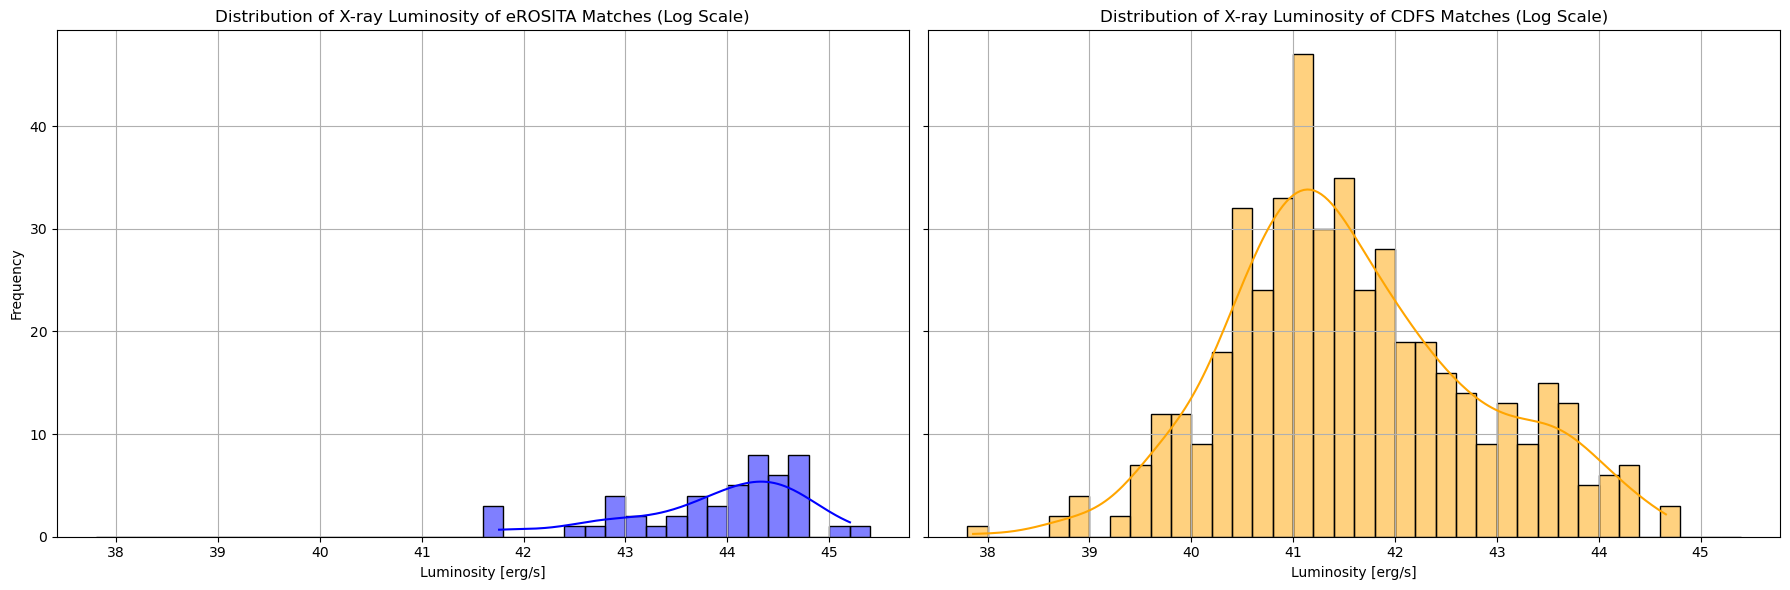

In [312]:
luminosity_erosita = edff_erosita_computed['L_x']
log_combined_luminosity_erosita = np.log10(luminosity_erosita[luminosity_erosita > 0])

luminosity_cdfs = edff_cdfs_computed['L_x']
log_combined_luminosity_cdfs = np.log10(luminosity_cdfs[luminosity_cdfs > 0])

min_log_lum = np.floor(min(log_combined_luminosity_erosita.min(), log_combined_luminosity_cdfs.min()) * 10) / 10
max_log_lum = np.ceil(max(log_combined_luminosity_erosita.max(), log_combined_luminosity_cdfs.max()) * 10) / 10
bin_edges = np.arange(min_log_lum, max_log_lum + 0.2, 0.2)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.histplot(log_combined_luminosity_erosita, bins=bin_edges, kde=True, ax=axes[0], color='blue')
axes[0].set_xlabel('Luminosity [erg/s]')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of X-ray Luminosity of eROSITA Matches (Log Scale)')
axes[0].grid(True)

sns.histplot(log_combined_luminosity_cdfs, bins=bin_edges, kde=True, ax=axes[1], color='orange')
axes[1].set_xlabel('Luminosity [erg/s]')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of X-ray Luminosity of CDFS Matches (Log Scale)')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('plots/erosita_cdfs_xray_dist.png')
plt.show()

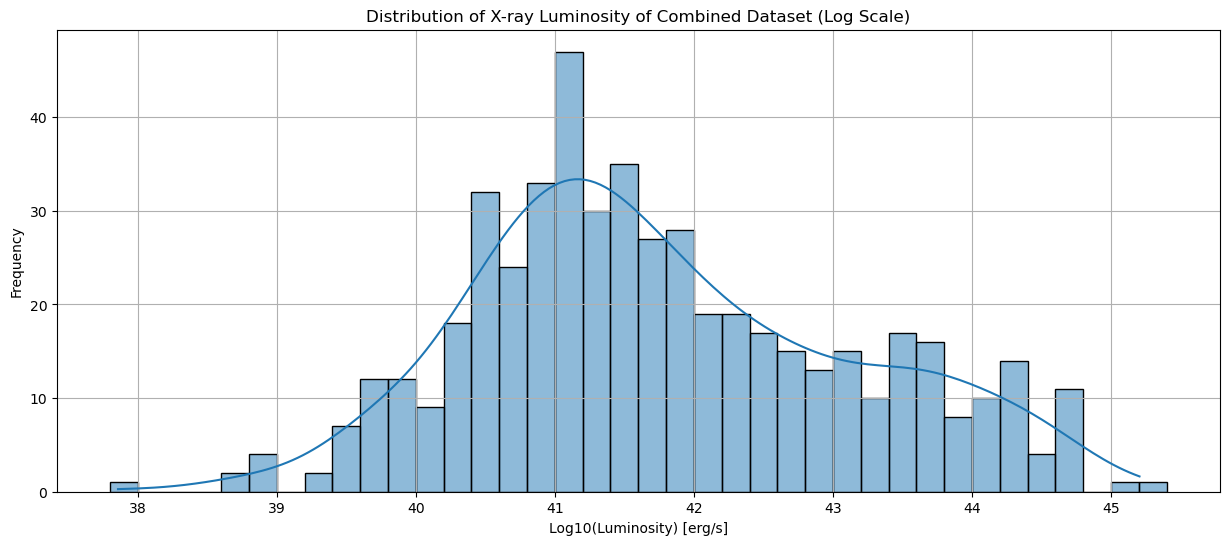

In [313]:
combined_luminosity = combined_computed['L_x']
log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

min_log_lum = np.floor(log_combined_luminosity.min() * 10) / 10
max_log_lum = np.ceil(log_combined_luminosity.max() * 10) / 10
bin_edges = np.arange(min_log_lum, max_log_lum + 0.2, 0.2)

plt.figure(figsize=(15, 6))
sns.histplot(log_combined_luminosity, bins=bin_edges, kde=True)
plt.xlabel('Log10(Luminosity) [erg/s]')
plt.ylabel('Frequency')
plt.title('Distribution of X-ray Luminosity of Combined Dataset (Log Scale)')
plt.grid(True)

plt.savefig('plots/combined_xray_dist.png')
plt.show()

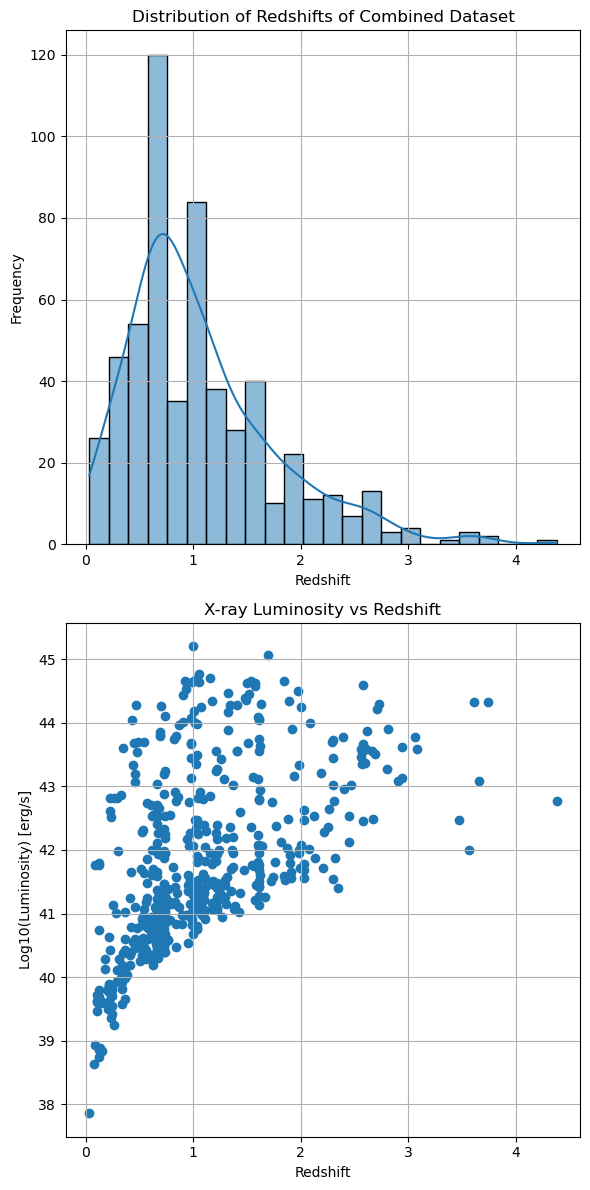

In [314]:
combined_redshifts = pd.concat([edff_cdfs_computed['z'], edff_erosita_computed['z']], ignore_index=True)
combined_luminosity = pd.concat([edff_cdfs_computed['L_x'], edff_erosita_computed['L_x']], ignore_index=True)

log_combined_luminosity = np.log10(combined_luminosity[combined_luminosity > 0])

fig, axes = plt.subplots(2, 1, figsize=(6, 12))

sns.histplot(combined_redshifts, kde=True, ax=axes[0])
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Redshifts of Combined Dataset')
axes[0].grid(True)

axes[1].scatter(combined_redshifts[combined_luminosity > 0], log_combined_luminosity)
axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('Log10(Luminosity) [erg/s]')
axes[1].set_title('X-ray Luminosity vs Redshift')
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.savefig('plots/erosita_cdfs_redshift_dist.png')
plt.show()

## SED Analysis

In [315]:
def generate_sed(df):
    sed_dicts = []
    for _, row in df.iterrows():
        wavelengths_rest = np.array([wavelength_dict[w] / (1e4 * (1 + row['z'])) for w in wavelength_dict])
        luminosities = row[['L_x','L_u', 'L_g', 'L_r', 'L_i', 'L_z', 'L_ch1', 'L_ch2']].values
        fluxes = row[['F_x','F_u', 'F_g', 'F_r', 'F_i', 'F_z', 'F_ch1', 'F_ch2']].values
        edffID = row['edffID']
        redshift = row['z']
        sed_data_dict = {
            'wavelength': wavelengths_rest,
            'L' : luminosities,
            'F': fluxes,
            'edffID': edffID,
            'redshift': redshift, 
        }
        sed_dicts.append(sed_data_dict)
    return sed_dicts

combined_sed_dicts = generate_sed(combined_computed)
edff_cdfs_sed_dicts = generate_sed(edff_cdfs_computed)
edff_erosita_sed_dicts = generate_sed(edff_erosita_computed)

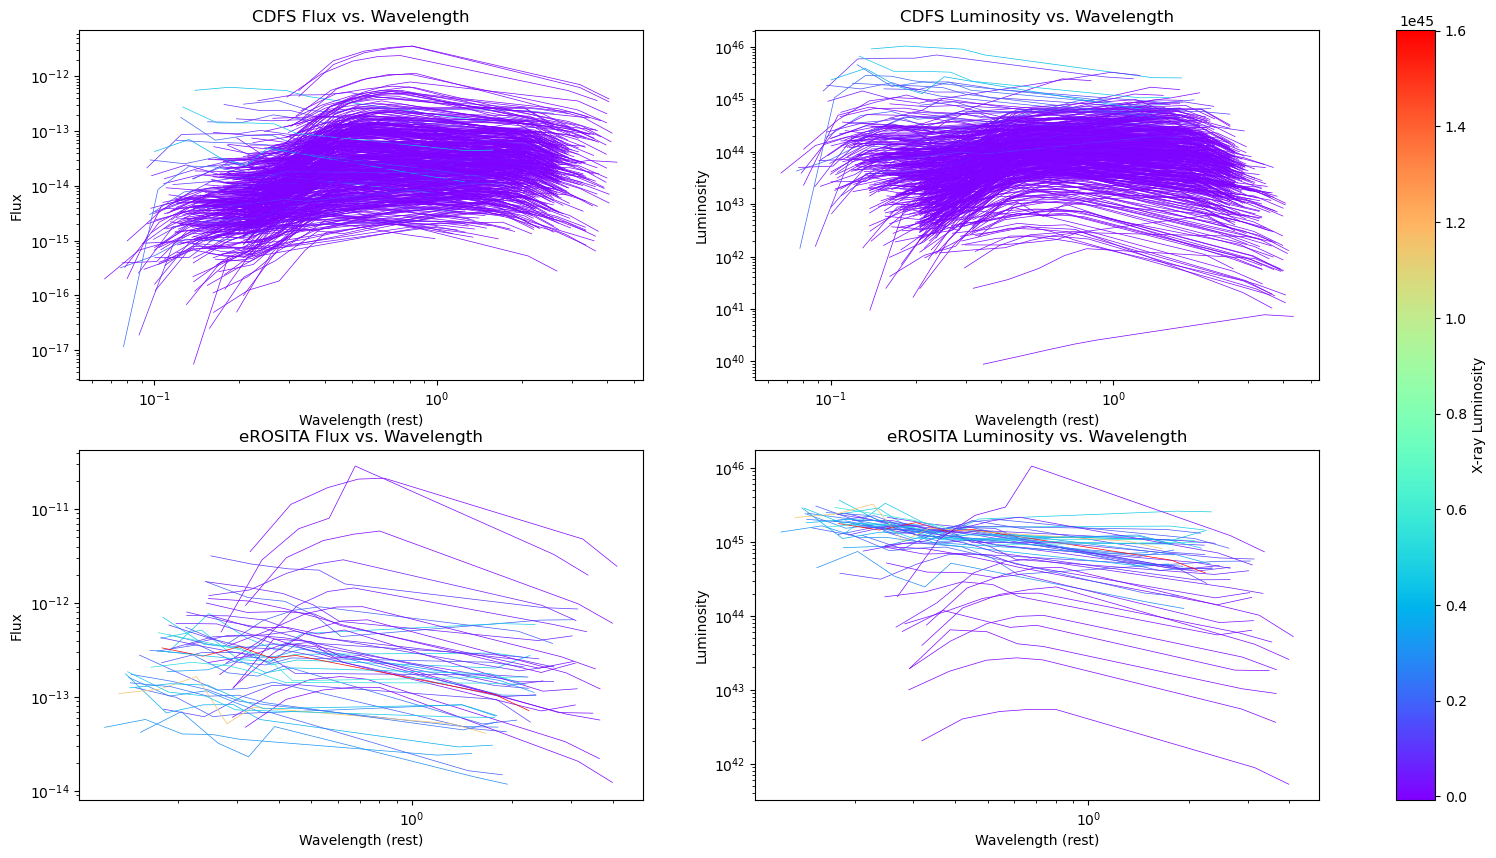

In [316]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

cmap = plt.colormaps['rainbow']
normalize = plt.Normalize(vmin=min([d['L'][0] for d in combined_sed_dicts]), vmax=max([d['L'][0] for d in combined_sed_dicts]))

for sed_dict in edff_cdfs_sed_dicts:
    color = cmap(normalize(sed_dict['L'][0]))
    axs[0][0].plot(sed_dict['wavelength'][1:], sed_dict['F'][1:], color=color, linewidth=0.5)
    axs[0][1].plot(sed_dict['wavelength'][1:], sed_dict['L'][1:], color=color, linewidth=0.5)

for sed_dict in edff_erosita_sed_dicts:
    color = cmap(normalize(sed_dict['L'][0]))
    axs[1][0].plot(sed_dict['wavelength'][1:], sed_dict['F'][1:], color=color, linewidth=0.5)
    axs[1][1].plot(sed_dict['wavelength'][1:], sed_dict['L'][1:], color=color, linewidth=0.5)


axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[0][0].set_xlabel('Wavelength (rest)')
axs[0][0].set_ylabel('Flux')
axs[0][0].set_title('CDFS Flux vs. Wavelength')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[0][1].set_xlabel('Wavelength (rest)')
axs[0][1].set_ylabel('Luminosity')
axs[0][1].set_title('CDFS Luminosity vs. Wavelength')

axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')
axs[1][0].set_xlabel('Wavelength (rest)')
axs[1][0].set_ylabel('Flux')
axs[1][0].set_title('eROSITA Flux vs. Wavelength')

axs[1][1].set_xscale('log')
axs[1][1].set_yscale('log')
axs[1][1].set_xlabel('Wavelength (rest)')
axs[1][1].set_ylabel('Luminosity')
axs[1][1].set_title('eROSITA Luminosity vs. Wavelength')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', label='X-ray Luminosity')

plt.savefig('plots/erosita_cdfs_seds.png')
plt.show()


In [317]:
def normalize_sed_at_wavelength(sed_dicts, norm_wavelength=1):
    normalized_sed_dicts = []
    for sed_dict in sed_dicts:
        # Interpolate the flux and luminosity at the normalization wavelength
        interp_flux = interp1d(sed_dict['wavelength'], sed_dict['F'], kind='linear', fill_value="extrapolate")
        interp_lum = interp1d(sed_dict['wavelength'], sed_dict['L'], kind='linear', fill_value="extrapolate")
        
        norm_flux = interp_flux(norm_wavelength)
        norm_luminosity = interp_lum(norm_wavelength)

        # Normalize the fluxes and luminosities
        normalized_fluxes = sed_dict['F'] / norm_flux
        normalized_luminosities = sed_dict['L'] / norm_luminosity

        normalized_sed_data_dict = {
            'wavelength': sed_dict['wavelength'],
            'L': normalized_luminosities,
            'F': normalized_fluxes,
            'edffID': sed_dict['edffID'],
            'redshift': sed_dict['redshift'],
            'original_L': sed_dict['L']  # Keep the original luminosity for coloring
        }
        normalized_sed_dicts.append(normalized_sed_data_dict)
    return normalized_sed_dicts

def plot_normalized_sed(sed_dicts, ax_flux, ax_lum, cmap):
    all_wavelengths = []
    all_fluxes = []
    all_luminosities = []

    for sed_dict in sed_dicts:
        # Use the original X-ray Luminosity for coloring
        color = cmap(sed_dict['L'][0])
        ax_flux.plot(sed_dict['wavelength'][1:], sed_dict['F'][1:], color=color, linewidth=0.5)
        ax_lum.plot(sed_dict['wavelength'][1:], sed_dict['L'][1:], color=color, linewidth=0.5)

        all_wavelengths.append(sed_dict['wavelength'])
        all_fluxes.append(sed_dict['F'])
        all_luminosities.append(sed_dict['L'])

    # Convert lists to numpy arrays for easier manipulation
    all_wavelengths = np.array(all_wavelengths)
    all_fluxes = np.array(all_fluxes)
    all_luminosities = np.array(all_luminosities)

    # Compute median fluxes and luminosities at each wavelength
    median_fluxes = np.median(all_fluxes, axis=0)
    median_luminosities = np.median(all_luminosities, axis=0)

    # Plot median lines
    ax_flux.plot(sed_dict['wavelength'][1:], median_fluxes[1:], color='black', linewidth=2, label='Median')
    ax_lum.plot(sed_dict['wavelength'][1:], median_luminosities[1:], color='black', linewidth=2, label='Median')

    ax_flux.legend()
    ax_lum.legend()

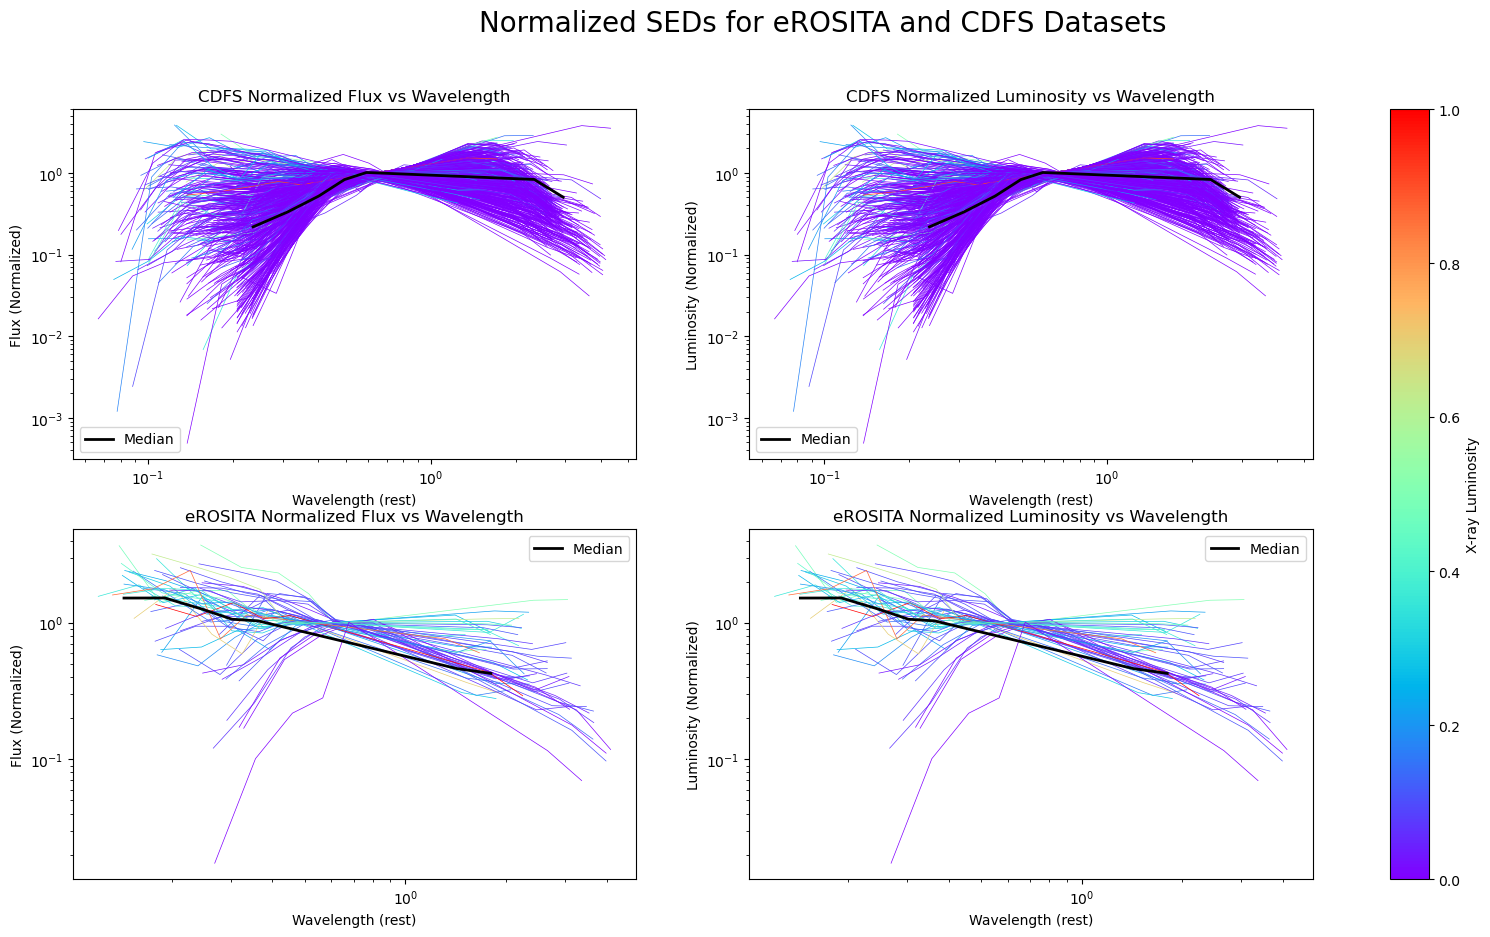

In [318]:
norm_wavelength = 0.7  # Normalization wavelength

# Normalize the SEDs
normalized_combined_sed_dicts = normalize_sed_at_wavelength(combined_sed_dicts, norm_wavelength)
normalized_edff_cdfs_sed_dicts = normalize_sed_at_wavelength(edff_cdfs_sed_dicts, norm_wavelength)
normalized_edff_erosita_sed_dicts = normalize_sed_at_wavelength(edff_erosita_sed_dicts, norm_wavelength)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Define the colormap
cmap = plt.colormaps['rainbow']

# Plot the normalized SEDs
plot_normalized_sed(normalized_edff_cdfs_sed_dicts, axs[0][0], axs[0][1], cmap)
plot_normalized_sed(normalized_edff_erosita_sed_dicts, axs[1][0], axs[1][1], cmap)

# Set plot labels and titles
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[0][0].set_xlabel('Wavelength (rest)')
axs[0][0].set_ylabel('Flux (Normalized)')
axs[0][0].set_title('CDFS Normalized Flux vs Wavelength')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[0][1].set_xlabel('Wavelength (rest)')
axs[0][1].set_ylabel('Luminosity (Normalized)')
axs[0][1].set_title('CDFS Normalized Luminosity vs Wavelength')

axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')
axs[1][0].set_xlabel('Wavelength (rest)')
axs[1][0].set_ylabel('Flux (Normalized)')
axs[1][0].set_title('eROSITA Normalized Flux vs Wavelength')

axs[1][1].set_xscale('log')
axs[1][1].set_yscale('log')
axs[1][1].set_xlabel('Wavelength (rest)')
axs[1][1].set_ylabel('Luminosity (Normalized)')
axs[1][1].set_title('eROSITA Normalized Luminosity vs Wavelength')

# Adding colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', label='X-ray Luminosity')
fig.suptitle('Normalized SEDs for eROSITA and CDFS Datasets', fontsize=20)

plt.savefig('plots/erosita_cdfs_seds_median.png')
plt.show()

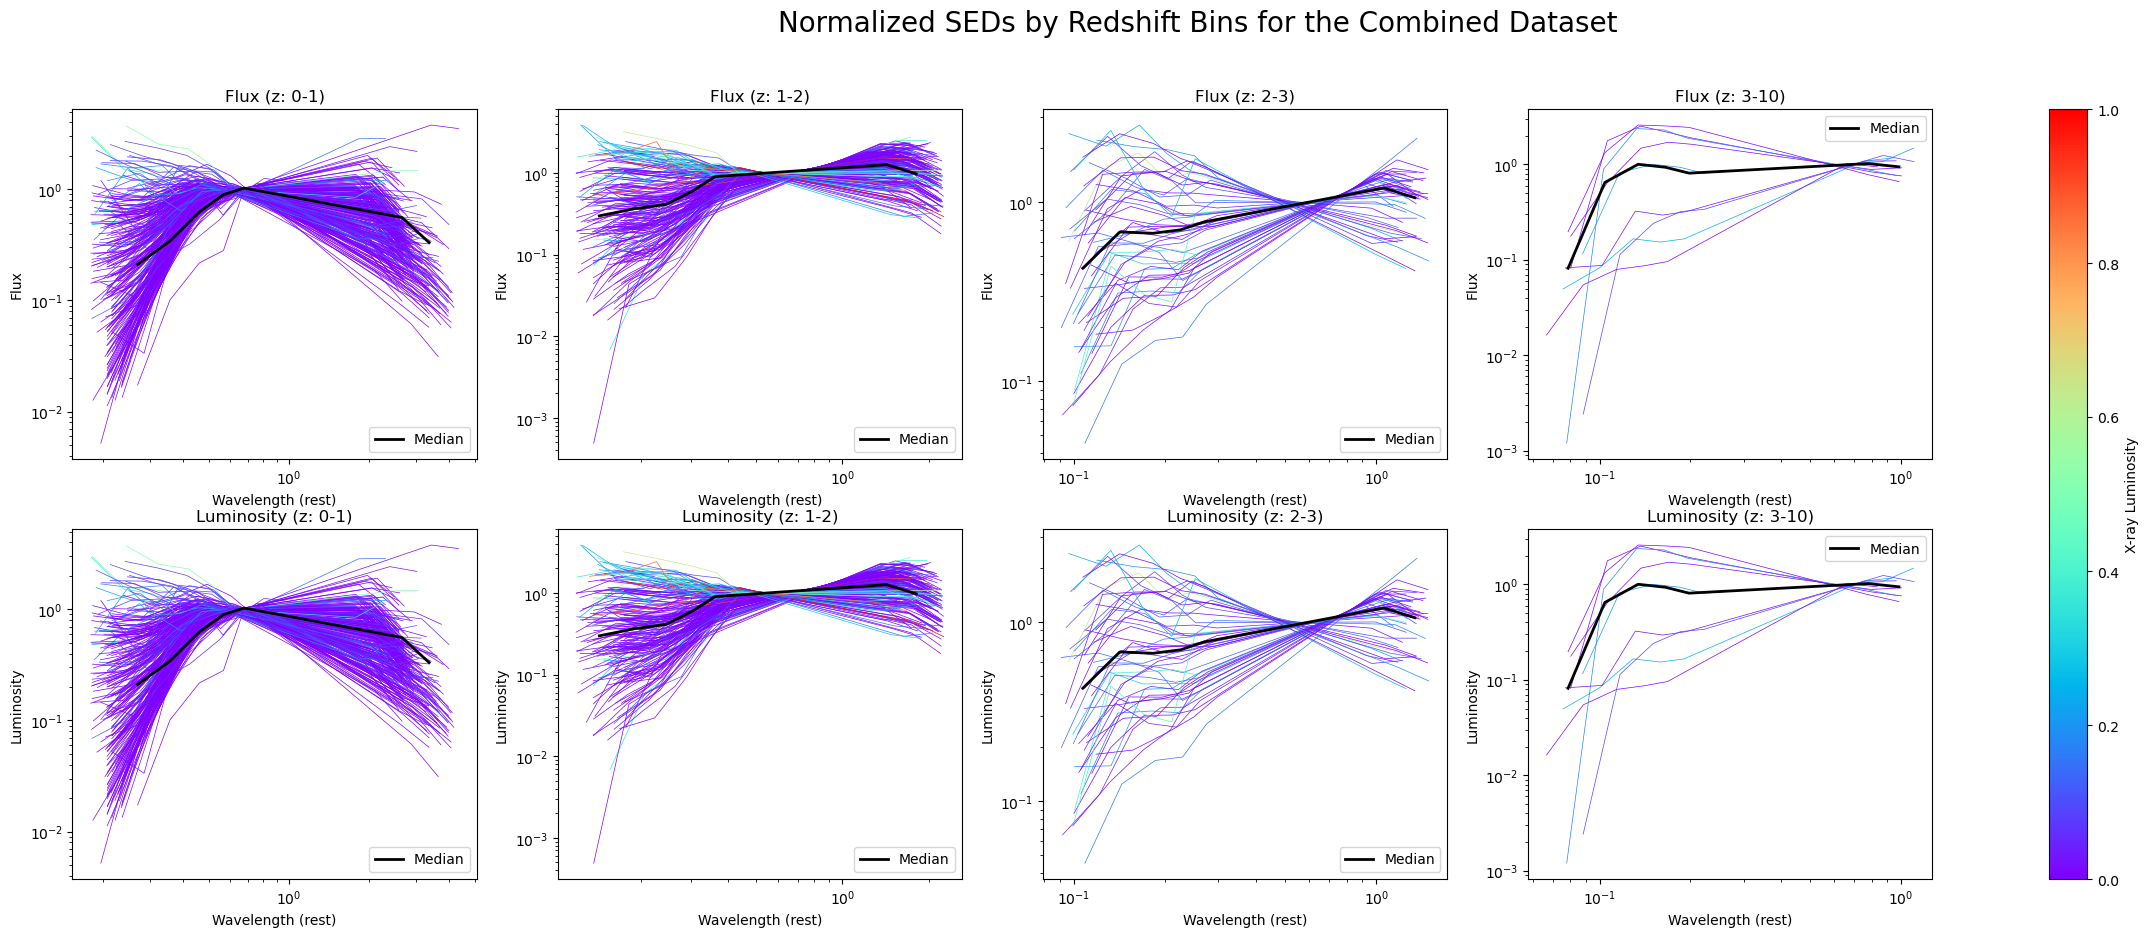

In [319]:
# Define redshift bins
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 10)]

fig, axs = plt.subplots(2, 4, figsize=(30, 10))

cmap = plt.colormaps['rainbow']

for i, (z_min, z_max) in enumerate(redshift_bins):
    ax_flux = axs[0, i]
    ax_lum = axs[1, i]
    sed_bin = [sed_dict for sed_dict in normalized_combined_sed_dicts if z_min <= sed_dict['redshift'] < z_max]
    plot_normalized_sed(sed_bin, ax_flux, ax_lum, cmap)

    ax_flux.set_xscale('log')
    ax_flux.set_yscale('log')
    ax_flux.set_xlabel('Wavelength (rest)')
    ax_flux.set_ylabel('Flux')
    ax_flux.set_title(f'Flux (z: {z_min}-{z_max})')

    ax_lum.set_xscale('log')
    ax_lum.set_yscale('log')
    ax_lum.set_xlabel('Wavelength (rest)')
    ax_lum.set_ylabel('Luminosity')
    ax_lum.set_title(f'Luminosity (z: {z_min}-{z_max})')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', label='X-ray Luminosity')
fig.suptitle('Normalized SEDs by Redshift Bins for the Combined Dataset', fontsize=20)

plt.savefig('plots/combined_seds_redshift_bins.png')
plt.show()


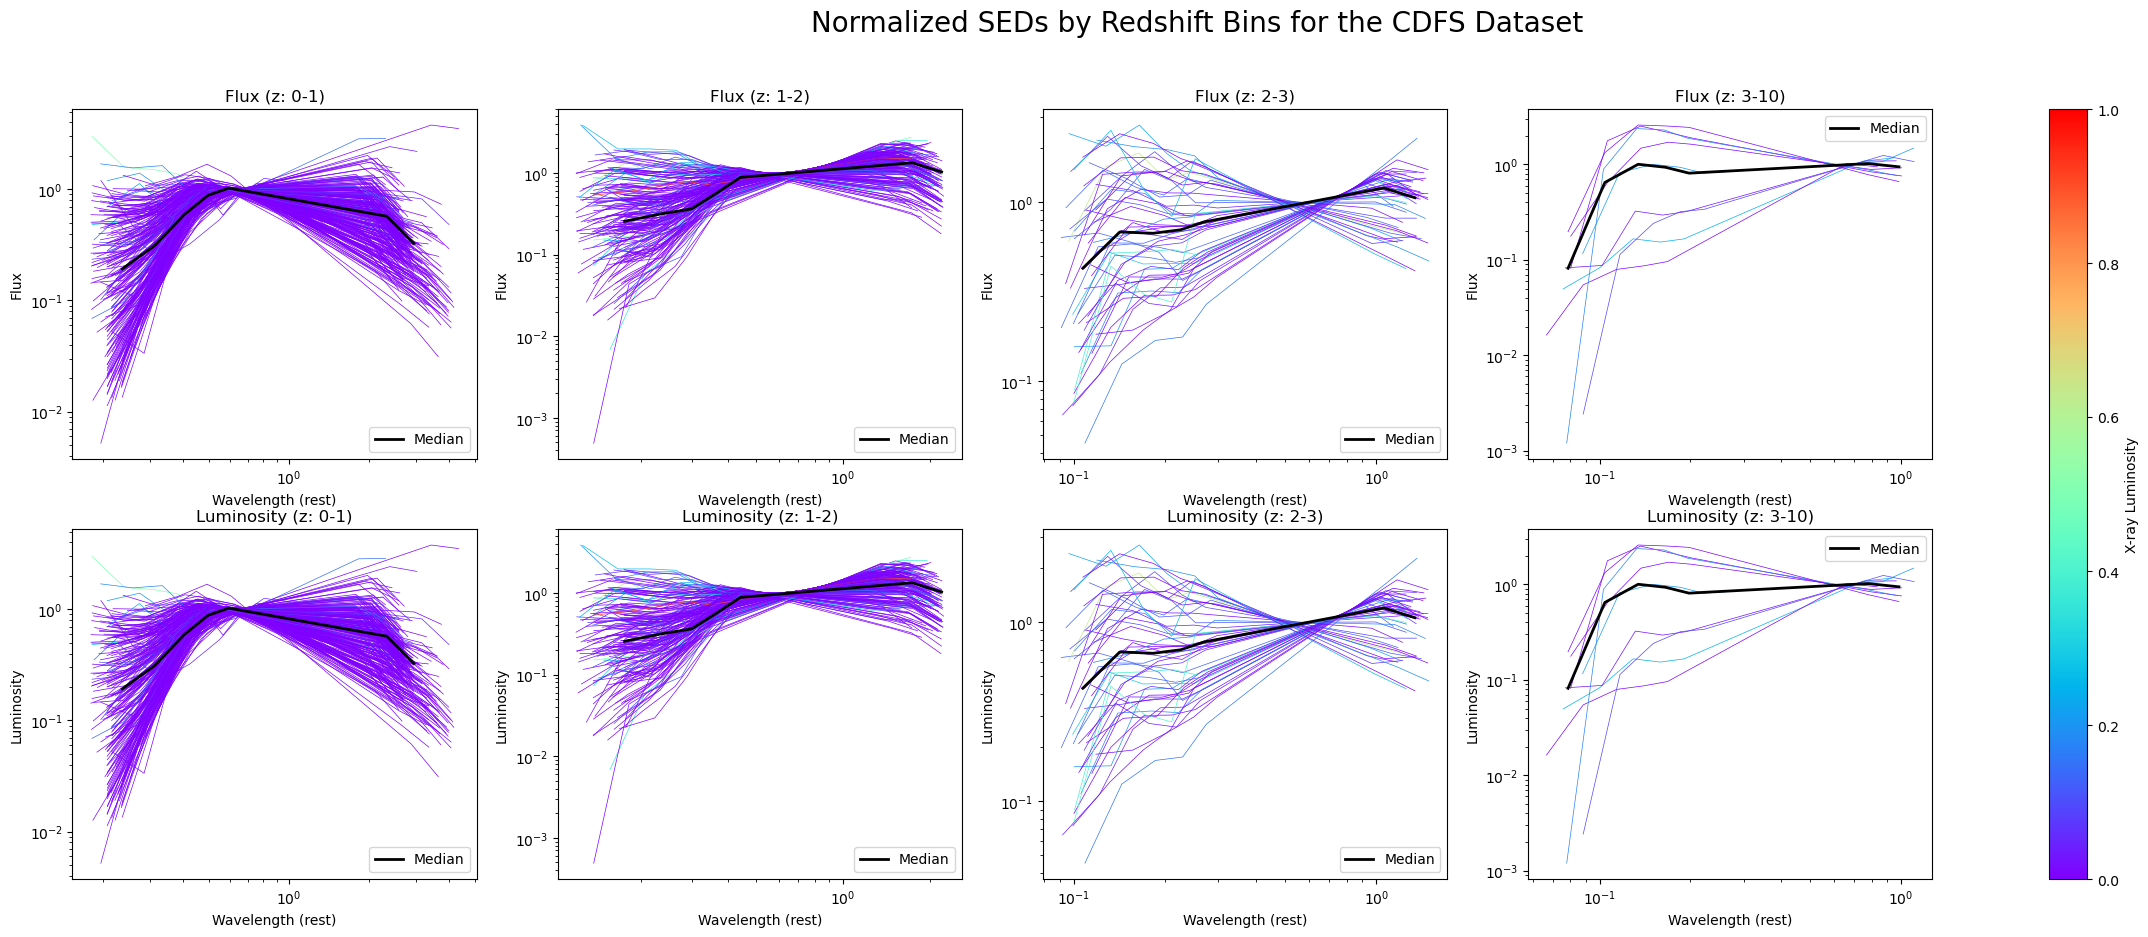

In [320]:
# Define redshift bins
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 10)]

fig, axs = plt.subplots(2, 4, figsize=(30, 10))

cmap = plt.colormaps['rainbow']

for i, (z_min, z_max) in enumerate(redshift_bins):
    ax_flux = axs[0, i]
    ax_lum = axs[1, i]
    sed_bin = [sed_dict for sed_dict in normalized_edff_cdfs_sed_dicts if z_min <= sed_dict['redshift'] < z_max]
    plot_normalized_sed(sed_bin, ax_flux, ax_lum, cmap)

    ax_flux.set_xscale('log')
    ax_flux.set_yscale('log')
    ax_flux.set_xlabel('Wavelength (rest)')
    ax_flux.set_ylabel('Flux')
    ax_flux.set_title(f'Flux (z: {z_min}-{z_max})')

    ax_lum.set_xscale('log')
    ax_lum.set_yscale('log')
    ax_lum.set_xlabel('Wavelength (rest)')
    ax_lum.set_ylabel('Luminosity')
    ax_lum.set_title(f'Luminosity (z: {z_min}-{z_max})')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', label='X-ray Luminosity')

fig.suptitle('Normalized SEDs by Redshift Bins for the CDFS Dataset', fontsize=20)

plt.savefig('plots/cdfs_seds_flux_luminosity_bins.png')
plt.show()


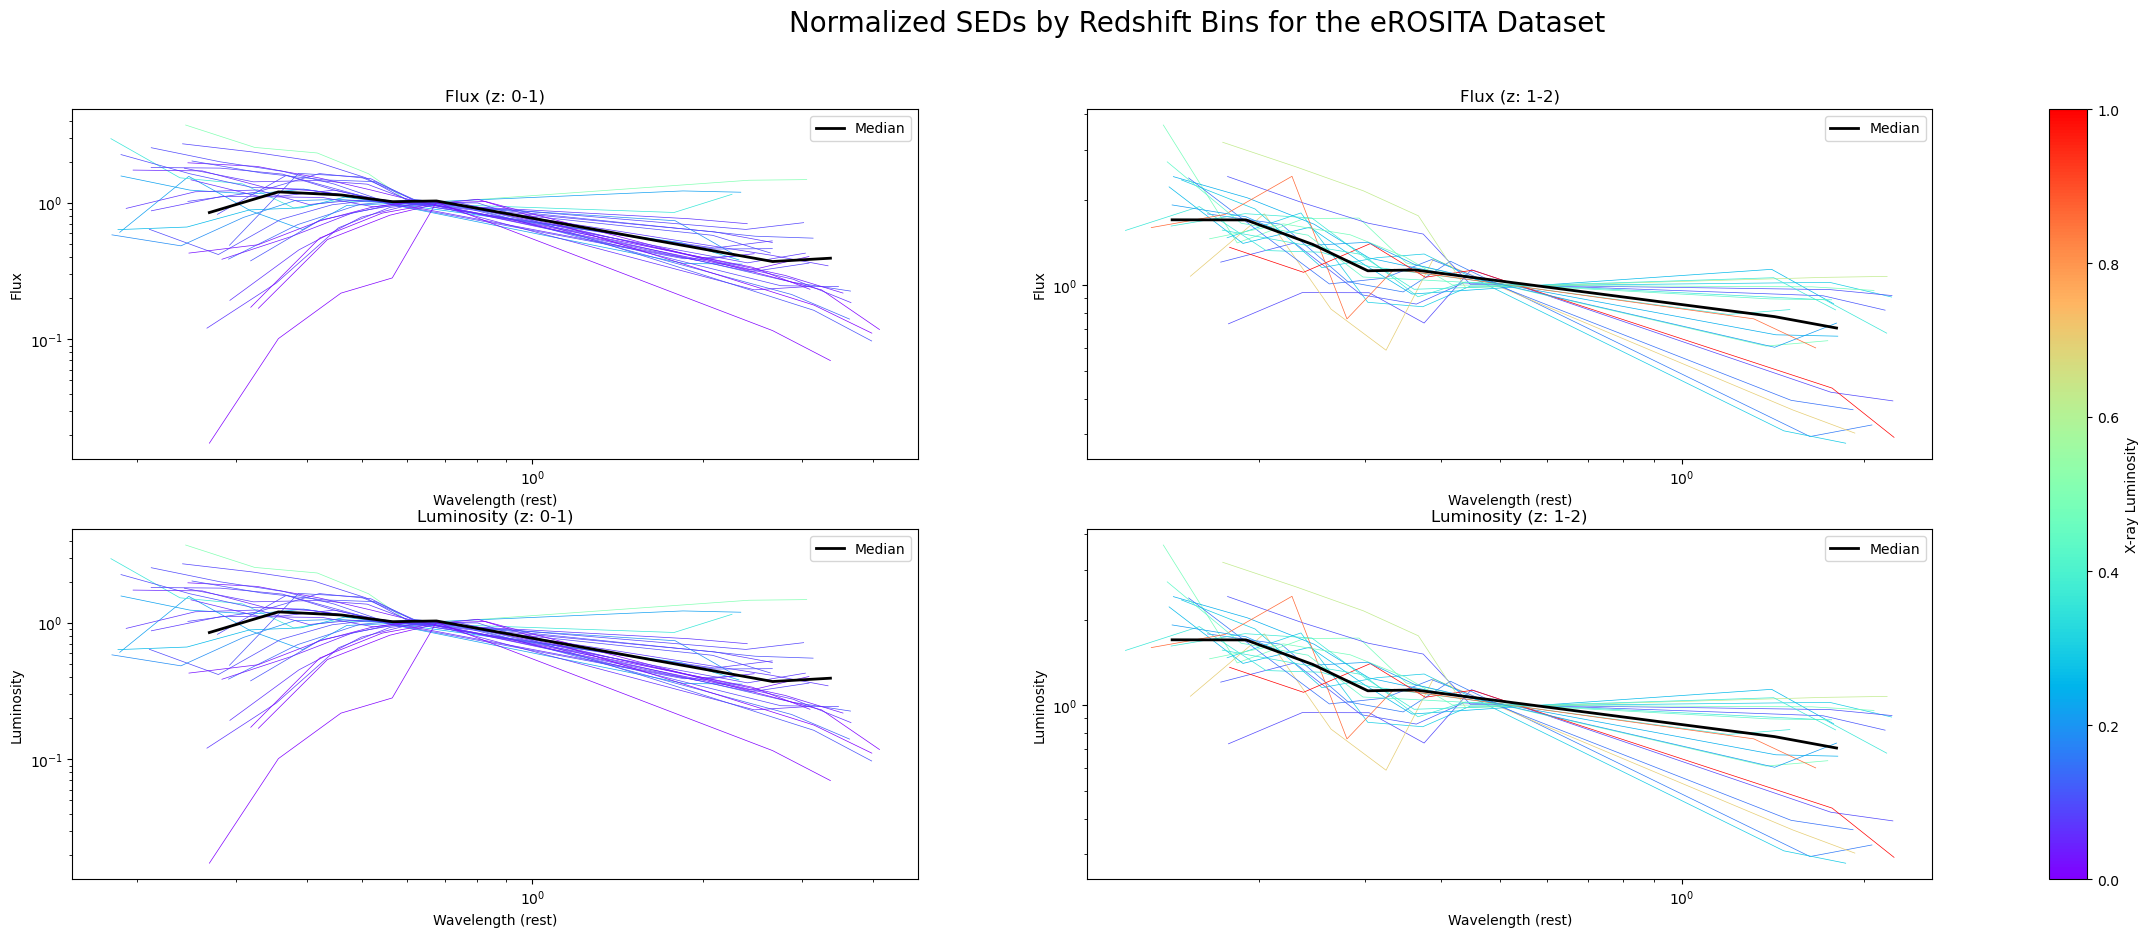

In [321]:
# Define redshift bins
redshift_bins = [(0, 1), (1, 2)]

fig, axs = plt.subplots(2, 2, figsize=(30, 10))

cmap = plt.colormaps['rainbow']
normalize = plt.Normalize(vmin=min([d['L'][0] for d in normalized_edff_erosita_sed_dicts]), vmax=max([d['L'][0] for d in normalized_edff_erosita_sed_dicts]))

for i, (z_min, z_max) in enumerate(redshift_bins):
    ax_flux = axs[0, i]
    ax_lum = axs[1, i]
    sed_bin = [sed_dict for sed_dict in normalized_edff_erosita_sed_dicts if z_min <= sed_dict['redshift'] < z_max]
    plot_normalized_sed(sed_bin, ax_flux, ax_lum, cmap)

    ax_flux.set_xscale('log')
    ax_flux.set_yscale('log')
    ax_flux.set_xlabel('Wavelength (rest)')
    ax_flux.set_ylabel('Flux')
    ax_flux.set_title(f'Flux (z: {z_min}-{z_max})')

    ax_lum.set_xscale('log')
    ax_lum.set_yscale('log')
    ax_lum.set_xlabel('Wavelength (rest)')
    ax_lum.set_ylabel('Luminosity')
    ax_lum.set_title(f'Luminosity (z: {z_min}-{z_max})')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', label='X-ray Luminosity')

fig.suptitle('Normalized SEDs by Redshift Bins for the eROSITA Dataset', fontsize=20)

plt.savefig('plots/erosita_seds_redshift_bins.png')
plt.show()


## To Do
* Plot redshift bins
* remove x-ray 
* Normalized at 1 micron
* plot luminosity bins
* Plot Individual SEDs
* Maybe plot median line

## Other options
* Machine Learning
* Preliminary Cigale fit 
